In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import seaborn as sns
import pandas as pd
from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors, datasets

In [2]:
from helpers import plotPairwiseDecisionTrees

# Lecture 9: Kaggle 2 kNN, Decision Trees, Random Forest, Ensemble Learning
## 11/6/18

### Hosted by and maintained by the [Statistics Undergraduate Students Association (SUSA)](https://susa.berkeley.edu). Updated and maintained by [Ajay Raj](mailto:araj@berkeley.edu)

#### Originally authored by [Calvin Chen](mailto:chencalvin99@berkeley.edu), [Michelle Hao](mailto:mhao@berkeley.edu), and [Patrick Chao](mailto:prc@berkeley.edu).
        

## Classification

Decision trees rely a series of yes or no questions to make a decision on which class an input point falls under. You've seen decision trees your entire life. Here's one made by Rosa Choe, a beloved member of the club that graduated last semester.

<img src='pictures/meme.png' width=40%>

Meme credit to $\text{Rosa Choe}^{\text{TM}}$.

As we can see from the tree above, we are able to answer a yes or no question at every step, and depending on our answer, we either went one way or another through the tree. They are very synonymous to flowcharts, but we'll go into more intricacies with decision trees later on.

Now let's apply this to the data science setting for a classification task. In particular, you're given a data point $X = \begin{bmatrix} X_1 & X_2 & ... & X_k \end{bmatrix}$, and you want to assign it a class $c$. We've seen examples of this before: logistic regression from last week tries to assign a class $c \in \{0, 1\}$ for each data point by predicting $\mathbb{P}(X = 1)$.

For a decision tree to work for this, we want to look at $X$, ask yes-no questions about its features, and assign it to a class.

<a id='dataset'></a>
### The Dataset

<img src='pictures/iris.jpg' width="250" height="250">
<center> Image from: A Complete Guide to K-Nearest-Neighbors by Zakka </center>

The dataset we'll be using is the [Iris Flower Dataset](https://archive.ics.uci.edu/ml/datasets/Iris). It contains a series of observations on three species of Iris (Iris setosa, Iris virginica, and Iris verisolor). Each observation contains four features: the *petal length, petal width, sepal length, and sepal width*. The **question** we're asking today is: can we predict the species of Iris from its *petal length, petal width, sepal length, and sepal width*.

In [3]:
#importing the data
iris = datasets.load_iris()
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= ['Sepal Length', 'Sepal Width','Petal Length','Petal Width'] + ['species'])

#y contains the correct classifications (0, 1, 2 for each type of Iris)
Y = iris["species"]


#### Summarize the dataset

In [4]:
iris.describe()

,Sepal Length,Sepal Width,Petal Length,Petal Width,species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [5]:
# Let’s now take a look at the number of instances (rows) that 
# belong to each class. We can view this as an absolute count.
iris.groupby('species').size()

species
0.0    50
1.0    50
2.0    50
dtype: int64

#### Dividing the Dataframe into Feature and Labels

In [6]:
feature_columns = ['Sepal Length', 'Sepal Width','Petal Length','Petal Width']
X = iris[feature_columns].values
Y = iris['species'].values

# Alternative way of selecting features and labels arrays:
# X = dataset.iloc[:, 1:5].values
# y = dataset.iloc[:, 5].values

#### Splitting the Data into Train and Test Sets

In [7]:
#Splitting dataset into training and test
from sklearn.model_selection import train_test_split
X_train_iris, X_test_iris, Y_train_iris, Y_test_iris = train_test_split(X, Y, test_size = 0.2, random_state = 0)

An example decision tree to solve this **classification** task could look as follows:

<img src='pictures/Example Decision Tree.png'>

Let's see how this decision tree fares on our training data.

In [8]:
class TreeNode:
    
    def __init__(self, left=None, right=None, split_fn=None, leaf_evaluate=None):
        self.left = left
        self.right = right
        self.split_fn = split_fn
        self.leaf_evaluate = leaf_evaluate
    
    def is_leaf(self):
        return self.left == None and self.right == None
    
    def evaluate(self, X_i):
        if self.is_leaf():
            return self.leaf_evaluate()
        if self.split_fn(X_i):
            return self.left.evaluate(X_i)
        else:
            return self.right.evaluate(X_i)

class Leaf(TreeNode):
    
    def __init__(self, label):
        TreeNode.__init__(self, leaf_evaluate=lambda: label)

In [9]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / y_true.shape[0]

In [10]:
def predict(X, tree):
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    preds = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        preds[i] = tree.evaluate(X[i])
    return preds

In [11]:
root = TreeNode(
    split_fn=lambda X_i: X_i[0] > 5,
    left=TreeNode(
        split_fn=lambda X_i: X_i[2] > 3,
        left=Leaf(0),
        right=Leaf(2)
    ),
    right=TreeNode(
        split_fn=lambda X_i: X_i[3] > 3,
        left=Leaf(0),
        right=Leaf(2)
    )
)

In [12]:
preds = predict(X_train_iris, root)
preds[:5]

array([0., 0., 2., 0., 0.])

In [13]:
accuracy(preds, Y_train_iris)

0.008333333333333333

This decision tree is horrible! Maybe it's because we didn't try to train it on our data.

### Training a Decision Tree

The question is now: how do we choose how to make the splits? The answer, of course, comes from our training data.

To make things a little simpler, let's just examine the first ten data points.

In [14]:
X_train_small = X_train_iris[:10]
Y_train_small = Y_train_iris[:10]
X_train_small

array([[6.4, 3.1, 5.5, 1.8],
       [5.4, 3. , 4.5, 1.5],
       [5.2, 3.5, 1.5, 0.2],
       [6.1, 3. , 4.9, 1.8],
       [6.4, 2.8, 5.6, 2.2],
       [5.2, 2.7, 3.9, 1.4],
       [5.7, 3.8, 1.7, 0.3],
       [6. , 2.7, 5.1, 1.6],
       [5.9, 3. , 4.2, 1.5],
       [5.8, 2.6, 4. , 1.2]])

In [15]:
Y_train_small

array([2., 1., 0., 2., 2., 1., 0., 1., 1., 1.])

Say that our first split is based on sepal length (the first feature).

In [16]:
sl_0 = X_train_small[Y_train_small == 0][:, 0]
sl_1 = X_train_small[Y_train_small == 1][:, 0]
sl_2 = X_train_small[Y_train_small == 2][:, 0]

In [17]:
sl_0

array([5.2, 5.7])

In [18]:
sl_1

array([5.4, 5.2, 6. , 5.9, 5.8])

In [19]:
sl_2

array([6.4, 6.1, 6.4])

For our decision tree, how should we split on sepal length?

Just based on our training data, if we split on (Sepal Length > 6), we've isolated all irises that are class 2 (iris verisolor).

<img src='pictures/Simple Decision Tree.png'/>

I decided make the "No" choice "Iris virginica". Why do you think that is the case?

In [20]:
simple = TreeNode(
    split_fn=lambda X_i: X_i[0] > 6,
    left=Leaf(2),
    right=Leaf(1)
)

In [21]:
preds = predict(X_train_small, simple)
preds

array([2., 1., 1., 2., 2., 1., 1., 1., 1., 1.])

In [22]:
accuracy(preds, Y_train_small)

0.8

Pretty good! Now let's try to come up with a programmatic way of doing this.

The intuition behind making a good decision tree is optimizing our questions (or different steps in the decision tree) to be able *to split up the data into as different categories as possible*. For example in the iris case, we would like to find a split where we may separate the various irises as much as possible. 

This idea of "splitting" to separate our irises the most introduces the idea of **entropy**. We minimize the entropy, or randomness in each split section of the data.

<a id='entropy'></a>
### Entropy

To begin, let's first define what entropy is. In the context of machine learning, entropy is **the measure of disorder  within a set** or the **amount of surprise**.

Let's take a look at our training data, and the feature we chose to split on, **sepal length**.

In [23]:
sepal_length = X_train_small[:, 0]
sepal_length

array([6.4, 5.4, 5.2, 6.1, 6.4, 5.2, 5.7, 6. , 5.9, 5.8])

In [24]:
Y_train_small

array([2., 1., 0., 2., 2., 1., 0., 1., 1., 1.])

After we split on (Sepal Length > 6), we divided our data into two halves.

In [25]:
yes = Y_train_small[sepal_length > 6]
no = Y_train_small[sepal_length <= 6]

In [26]:
yes

array([2., 2., 2.])

In [27]:
no

array([1., 0., 1., 0., 1., 1., 1.])

Let's consider a different split: (Sepal Length > 5.5).

In [28]:
yes_bad = Y_train_small[sepal_length > 5.5]
no_bad = Y_train_small[sepal_length <= 5.5]

In [29]:
yes_bad

array([2., 2., 2., 0., 1., 1., 1.])

In [30]:
no_bad

array([1., 0., 1.])

Which split was better? The first, because once we made the split, *we were more sure of what class we should predict*. How can we quantify this?

The mathematical definition of entropy is:

$$H(\textbf{p}) = -\sum_i p_i \cdot \log(p_i)$$

where $H(\textbf{p})$ is equal to the total entropy of the data set, and $p_i$ is equal to the probability of something occurring.

**Something to note:** When you calculate the entropy on a subset with data points that are all the same class, you run into a mathematical error, which is because $\log_{2}(0)$ cannot be calculated. So, as an alternative to calculating $\log_{2}(0)$, we can bring in the following limit instead (meaning our terms with $p_i = 0$ become 0:

$$\lim _{p\to 0+}p\log(p)=0$$

A great visualization for different entropies is as follows:
<img src='pictures/Entropy.png' width='50%'>

Let's say $Pr(X = 1)$ is the probability that you flips a heads, where heads is represented by $1$ and tails is represented by $0$. From this, we can see that the y-value, $H(X)$ (or calculated entropy), is at a minimum when the chance of flipping a heads is $0$ or $1$, but is at a maximum when the chance of flipping a heads is $0.5$. In other words, the data subset is the most random when there is an equal probability of all classes, and minimized when there are probabilites of classes that are equal to $0$.

When we look at a set of y-values, the entropy is:

$$\sum_{\text{class $c_i$}} -\left(\text{proportion of $c_i$'s}\right) \cdot \log \left(\text{proportion of $c_i$'s}\right)$$

In [31]:
def H(y):
    def proportion(val, y):
        return (y == val).sum() / len(y)
    unique = set(y)
    return sum(-1 * proportion(val, y) * np.log2(proportion(val, y)) for val in unique)
        

Let's see how this comes into play in our splits.

In [32]:
original_entropy = H(Y_train_small)
original_entropy

1.4854752972273344

In our good split, our entropies were:

In [33]:
H(yes), H(no)

(0.0, 0.863120568566631)

In our bad split, our entropies were:

In [34]:
H(yes_bad), H(no_bad)

(1.4488156357251847, 0.9182958340544896)

Clearly, the first split was better, because we reduced entropy the most.

To combine these statistics together for one measure, we'll take the **weighted average**, weighting by the sizes of the two sets.

In [35]:
def weighted_entropy(yes, no):
    total_size = len(yes) + len(no)
    return (len(yes) / total_size) * H(yes) + (len(no) / total_size) * H(no)

In [36]:
H(Y_train_small)

1.4854752972273344

In [37]:
weighted_entropy(yes, no)

0.6041843979966417

In [38]:
weighted_entropy(yes_bad, no_bad)

1.289659695223976

This is huge! We now have a way to choose our splits for our decision tree: 

**Find the best split value (of each feature) that reduces our entropy from the original set the most!**

### Training

In [39]:
from scipy.stats import mode

def train(X_train, Y_train, max_depth=None):
    if len(Y_train) == 0:
        return Leaf(0)
    
    if len(set(Y_train)) == 1 or max_depth == 1:
        return Leaf(mode(Y_train).mode)
    
    def split_weighted_entropy(feature_idx, feature_value):
        feature = X_train[:, feature_idx]
        yes = Y_train[feature > feature_value]
        no = Y_train[feature <= feature_value]
        return weighted_entropy(yes, no)
    splits = np.zeros(X_train.shape)
    for feature_idx in range(X_train.shape[1]):
        for i, feature_value in enumerate(X_train[:, feature_idx]): # try to split on each X-value
            splits[i, feature_idx] = split_weighted_entropy(feature_idx, feature_value)
    
    max_idxs = X_train.argmax(axis=0)
    for col, max_idx in enumerate(max_idxs):
        splits[max_idx, col] = float('inf')
    
    i = np.argmin(splits)
    best_feature_idx = i % splits.shape[1]
    best_feature_value = X_train[i // splits.shape[1], best_feature_idx]
    
    yes = X_train[:, best_feature_idx] > best_feature_value
    no = X_train[:, best_feature_idx] <= best_feature_value
    
    tree = TreeNode(
        split_fn=lambda X_i: X_i[best_feature_idx] > best_feature_value,
        left=train(X_train[yes], Y_train[yes], max_depth=max_depth - 1 if max_depth is not None else None),
        right=train(X_train[no], Y_train[no], max_depth=max_depth - 1 if max_depth is not None else None)
    )
    
    return tree

In [40]:
tree = train(X_train_iris, Y_train_iris)

In [41]:
preds = predict(X_train_iris, tree)
accuracy(preds, Y_train_iris)

1.0

Whoa! We have a model that performs at 100% training accuracy! Let's see what happens when we try the model on the validation set.

In [42]:
preds = predict(X_test_iris, tree)
accuracy(preds, Y_test_iris)

0.9333333333333333

We're doing significantly worse, so we're probably overfitting.

### Regression

How can we use decision trees to perform regression?

When we decide to make a leaf, take the mean/median of the points that are left, instead of the mode.

### Titanic

In [43]:
titanic_train = pd.read_csv('titanic/train.csv')
titanic_test = pd.read_csv('titanic/test.csv')
titanic_survived = titanic_train['Survived']
titanic_train = titanic_train.drop('Survived', axis=1)

In [44]:
full_data = pd.concat((titanic_train, titanic_test), sort=False)

In [45]:
def feature_engineering(df):
    df = df.drop(['Name', 'PassengerId', 'Age', 'Ticket'], axis=1)
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().idxmax()) # fill with Southampton
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if s is not np.nan else 'U') # U for unassigned
    df['Fare'] = np.log(df['Fare'] + 1)
    df = df.drop('Cabin', axis=1)
    df = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'Sex', 'Deck'])
    
    df = df.drop('Deck_T', axis=1)
    
    return df
    

In [46]:
full_data_cleaned = feature_engineering(full_data)

In [47]:
full_data_cleaned.head()

,SibSp,Parch,Fare,Pclass_First,Pclass_Second,Pclass_Third,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,1,0,2.110213,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
1,1,0,4.280593,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,2.188856,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1
3,1,0,3.990834,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
4,0,0,2.202765,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1


In [48]:
titanic_train_cleaned = full_data_cleaned.iloc[:titanic_train.shape[0]]
titanic_test_cleaned = full_data_cleaned.iloc[titanic_train.shape[0]:]

In [49]:
X = titanic_train_cleaned.values
y = titanic_survived.values

In [50]:
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
tree = train(X_train_titanic, y_train_titanic.astype(int), max_depth=10) # for computation sake

In [52]:
preds = predict(X_train_titanic, tree)
accuracy(preds, y_train_titanic)

0.9002808988764045

In [53]:
preds = predict(X_valid_titanic, tree)
accuracy(preds, y_valid_titanic)

0.7877094972067039

We're clearly overfitting. Let's investigate why this is the case.

In a decision tree, if we group each of the training points into the leaves that they would be classified as, a **pure leaf** is one that points all of the same task.

The first fact to recognize is that it is always possible to get 100% training accuracy using a decision tree. How? Make every data point a leaf / make every leaf **pure**.

<img src="pictures/DecisionTreeError.png" width="60%">
Image from http://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/lecturenote17.html

What is wrong with making every leaf pure?

It doesn't generalize well to test points. The **decision boundaries** become too complicated.

### Controlling Overfitting

There are many ways to control overfitting in decision trees: today we'll talk about **max-depth**.

The **max-depth** parameter allows your tree to be cut off at a certain depth, which reduces overfitting by making the decision boundaries simpler.

In [54]:
tree = train(X_train_titanic, y_train_titanic.astype(int), max_depth=4)

In [55]:
preds = predict(X_train_titanic, tree)
accuracy(preds, y_train_titanic)

0.8146067415730337

In [56]:
preds = predict(X_valid_titanic, tree)
accuracy(preds, y_valid_titanic)

0.7932960893854749

#### Cross-Validation

**Max-depth** is called a *hyperparameter* in your model (a parameter for your training, but one that cannot be learned from the training data). There are many ways to find the optimal values for these *hyperparameters*. Today we'll be discussing one, **$k$-fold cross-validation**.

<img src="pictures/k-fold.png"/>

In this procedure, we isolate $\frac{1}{k}$ of the data as the temporary test set, train on the other data, and evaluate the model that is trained. We do this for each of the $k$ possibilities of test set, and look at the mean accuracy.

For each choice of hyperparameter, look at the mean accuracy over all possible folds and choose the choice that has the highest mean accuracy. Why does this do better than just trying all choices on one validation set: it makes the model more **robust**, and less dependent on one validation set.

In [57]:
# 5-Fold Cross Validation

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

max_depths = [6, 8, 10]

cv_scores = np.zeros(len(max_depths))

for i, max_depth in enumerate(max_depths):
    print('Training max_depth =', max_depth, end='\t')
    scores = np.zeros(5)
    for j, (train_index, test_index) in enumerate(kf.split(X_train_titanic)):
        train_X = X_train_titanic[train_index]
        train_y = y_train_titanic[train_index]
        valid_X = X_train_titanic[test_index]
        valid_y = y_train_titanic[test_index]
        tree = train(train_X, train_y.astype(int), max_depth=max_depth)
        preds = predict(valid_X, tree)
        scores[j] = accuracy(preds, valid_y)
    cv_scores[i] = scores.mean()
    print('accuracy = ', cv_scores[i])

Training max_depth = 6	accuracy =  0.7879247513050329
Training max_depth = 8	accuracy =  0.8020388062641584
Training max_depth = 10	accuracy =  0.7992810006894514


Below are a few examples of different decision trees. Let's continue to investigate the effect of the **max-depth** parameter.

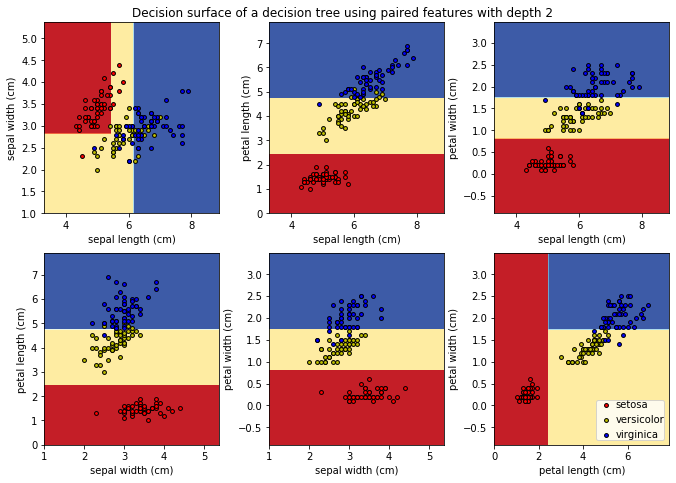

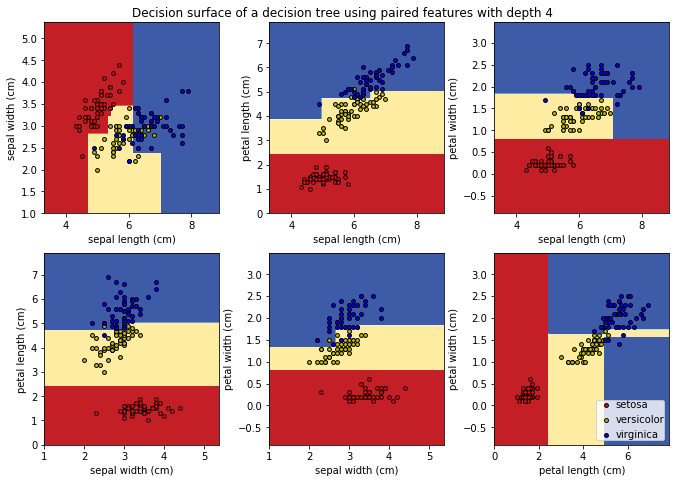

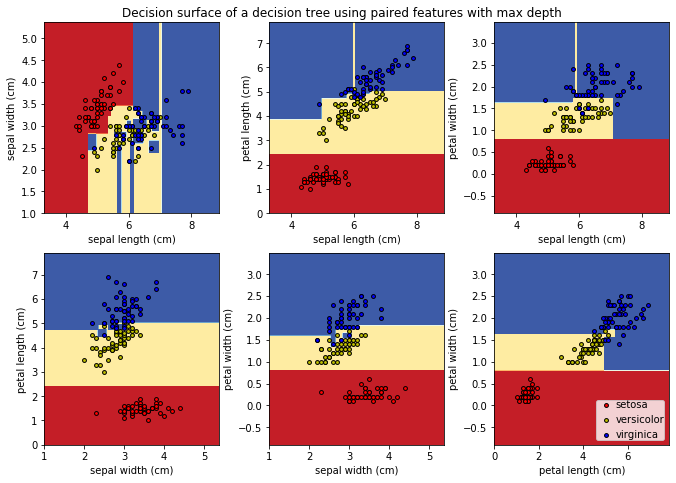

In [58]:
# From http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html
# Max Depth 2
plotPairwiseDecisionTrees(2)
# Max Depth 4
plotPairwiseDecisionTrees(4)
# No Max Depth
plotPairwiseDecisionTrees()

**Questions for understanding:**
> 1. What do the colored points and regions represent?
> 2. What are some trends as the trees get deeper?
> 3. How do the decision boundaries change with depth?

As we can see, the deeper our tree goes, the higher the variance is within the tree, as the decision tree is tailored towards our training data, and could be completely different had we just added/removed a couple data points. However, it also has low bias, as it won't consistently classify certain data points incorrectly (it's too precise!)

Now, we'd love to have a decision tree that had both low bias and low variance, but it seems like it's a tradeoff for one or the other. So, it'd be ideal to get the best of both worlds, and get low bias and low variance. But how?

Idea: **What if we got more models trained on our dataset?**

This idea of training more models on our training set introduces the idea of **ensemble learning**, which we will go into further in the next section, and help us solve our dilemna of wanting both low bias and low variance!

<a id='ensemble_learning'></a>
# Ensemble Learning

<img src='pictures/elephant.jpeg' width="700" height="700">

This is the fable of the blind men and the elephant. Each individual is correct in their own right, however together their descriptions paint a much more accurate picture.

We have discussed notions of bias and variance. To refresh these concepts again,  


**Bias** is how well the average model would perform if you trained models on many data sets.

**Variance** is how different the models you would obtain if you trained models on many data sets. 

In practice, we only have one data set. If we train a model on this dataset, we would like to minimize both bias and variance. However, we can use some techniques to try to get the best of both worlds.

Since bias is talking about how well the average model performs, and variance is about how varied the different models are, we can attempt to minimizing both of these by considering an *average model*.

Consider the following analogy.

<img src='pictures/weather.jpg' width="700" height="700">

We would like to predict the weather tomorrow. Perhaps we have $3$ separate sources for weather, Channel $4$ on TV, a online website, and the iPhone weather application. 

We may expect that a better estimate for the weather tomorrow is actually the average of all these estimates. Perhaps the different sources all have their own methods and data for creating a prediction, thus taking the average pools together all their resources into a more powerful estimator. 

The important gain of this approach is our improvement in variance. Keep in mind this is mentioning how different would another similar estimator be. While a single source may have high variation, such as an online website, we would expect another averaged weather amalgamation would be similar. If we considered Channel $5$ predictions, a different online website, and the Android weather application, we would not expect as much variation between their predictions since we already took the average of multiple sources. 

Thus, one technique to improve the quality of a model is to *train multiple models on the same data and pool their predictions*. This is known as **ensembling**.



<a id='bootstrapping_and_bagging'></a>
# Bootstrapping and Bagging
An important idea often used in data science is **bootstrapping**. This is a method to generate more samples of data, despite the fact that we only have a single dataset.

**Bootstrapping**: We take the original dataset of size $N$ and draw $M$ samples with replacement of size $N$. 

For example, if we would like to estimate the average height of people in the U.S., we may take a sample of $1000$ people and average their heights. However, this does not tell us much about the data other than the average. We pooled together $1000$ data points into a single value, but there is much more information available. 

What we can do is draw many samples with replacement of size $1000$, and compute the average heights of these. This mimics as if we had many dataset, and we have many average heights. Then we can compute a distribute of average heights we would have collected, and from this we can determine how good our estimate is. By the Central Limit theorem, this distribution of bootstrapped statistics should approach the normal distribution.

However, we are not limited to just calculating the average. We may calculate the median, standard deviation, or any other statistic of each bootstrapped sample. Furthermore, we can even create a model for each sample! This allows us to utilize the notion of training many models on the same dataset.

If we create many models and then aggregate our predictions, this is known as **bagging** (bootstrapp aggregating). Thus we may create many separate models that all are trained on separate data to obtain new predictions and better results.

The purpose of bagging is to decrease the variance of our model. Since we essentially take many models together in parallel, we avoid overfitting and decreasing variance.

<a id='random_forest'></a>
# Random Forest

A single decision tree often results in poor predictions, as they are very simple and lack much complexity. Just cutting the feature space into separate regions does not perform very well, as these strict linear constraints prevent complex boundaries.

However, if we include many decision trees and create a **random forest**, we obtain drastically better results. 
The idea of a random forest is quite simple, take many decision trees and output their average guess.
<center>
<img src="pictures/RandomForest.png" width="60%">
Image from https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d
</center>


In the case of classification, we take the most popular guess.   
In the case of regression, we take some form of the average guess.


Now, let's consider this exact setup. What would happen if we created many decision trees and took the most popular guess?

In practice, we could obtain the same decision tree over and over. This is because there is some optimal set of splitting values in the dataset to minimize entropy, even with different sets of data. Perhaps we have one feature that works very well in splitting the data, and it is always utilized as the first split in the tree. Then all decision trees end up looking quite similar, despite our efforts in bagging.

A solution to this problem is feature bagging. We may also select a subset of features for each tree to train on, thus each feature has a chance to be split on. 
<center>
<img src="pictures/RandomForestPipeline.jpg" width="40%">
Image from https://sites.google.com/site/rajhansgondane2506/publications
</center>


In summary, we begin with a dataset $\mathcal{D}$ of size $N$. 
1. We bootstrap the data so that we have $M$ new datasets $d_1,\ldots, d_M$ drawn with replacement of size $N$ from $\mathcal{D}$.
2. Select a subset of features $f_i$ for each new dataset $d_i$.
3. Fit a decision tree for each $d_i$ with features $f_i$.

Now to predict, we take the input data and feed it through each decision tree to get an output. Then we can take the most popular vote or the average output as the output of our model, based on the type of problem we are attempting to solve.

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
model = RandomForestClassifier(n_estimators=200, max_depth=10)

In [61]:
model.fit(X_train_titanic, y_train_titanic)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
accuracy(model.predict(X_valid_titanic), y_valid_titanic)

0.8268156424581006

<a id='boosting'></a>
# Boosting
We have mentioned bagging as a method of decreasing variance, but what about bias? There are also techniques to do this, namely **boosting**. This is a very popular technique in Kaggle competitions and most models that win competitions utilize huge ensembles of boosted random forests.

The exact implementation of boosting is out of scope for this discussion, but the main idea is to *fit your models sequentially rather than in parallel in bagging*.

In random forest, we take many samples of our data, and fit separate decision trees to each one. We account for similar decision trees by feature bagging as well. However, many of these decision trees will end up predicting similar things and essentially only reduce variance.

The key idea of boosting is to **emphasize the specific data points that we fail on**. Rather than trying to improve the prediction by considering the problem from different angles (e.g. new datasets from bagging or new features from feature bagging), consider where we predict incorrectly and attempt to improve our predictions from there.

<center>
<img src="pictures/Boosting.png" width="70%">
Image from https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/
</center>

This is similar to real life. If you would like to learn a new musical piece, it is more beneficial to practice the specific part that is challenging, rather than playing the entire piece from the start every time you mess up. By boosting our model, we attempt to place greater emphasis on the samples that we consistently misclassify.


For further reading, we highly recommend the following resources for explanations for boosting:  
https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/  
https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

Spectacular visualizations of decision trees and boosting:  
http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html

There are many forms of boosting in practice. Popular ones include: Adaboost, GradientBoost, and XGBoost. XGBoost is famous (or infamous) for excelling at Kaggle competitions, most winning solutions contain XGBoost (if not many). We encourage you to look at the links above (especially the vis